# Package Import

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Processing

In [2]:
def get_cali_param(img_url):
    imgs = glob.glob(img_url)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    objpts = [] 
    imgpts = [] 
    corner = (9, 6)
    for imge in imgs:
        img = mpimg.imread(imge)
        grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(grey, corner, None)
        if ret:
            objpts.append(objp)
            imgpts.append(corners)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
    print("Calibration Completed!")
    return mtx, dist

def get_undistort(distorted_img, mtx, dist, disp=False):
    undist = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    if disp:
        plt.imshow(undist)
        plt.title("Undistorted Image Example")
        plt.show()
    return undist

def inp_cali_file(path="./calibration.npz"):
        cali_param = np.load(path)
        return cali_param['mtx'], cali_param['dist']

class transform_perspective():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        self.has_display=False
        
    def transform(self, undist, display=False):
        transf_img=cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
        if display and not self.has_display:
            plt.imshow(transf_img)
            plt.title("Bird's Eye View Example")
            plt.show()
            self.has_display = True
        return transf_img
    
    def inverse_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))
    
def get_s_binary_con(undist_img, thres=(110, 255)):
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=21)
    return s_binary

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def adj_gamma_vals(image, gamma=1.0):
    if not hasattr(adj_gamma_vals, 'displayed'):
        adj_gamma_vals.displayed = False
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    adj_img=cv2.LUT(image, table)
    if not adj_gamma_vals.displayed:
        plt.imshow(adj_img)  
        plt.title('Adjusted Gamma Image')
        plt.show()
        adj_gamma_vals.displayed = True  
    return adj_img

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adj_gamma_vals(undist_img, 0.2)
    grey = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(grey, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(grey, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    slope_binary = gaussian_blur(slope_binary, kernel_size=9)
    return slope_binary

def color_slope_thresh_conv(undist_img):
    if not hasattr(color_slope_thresh_conv, 'displayed'):
        color_slope_thresh_conv.displayed = False 
    if not hasattr(color_slope_thresh_conv, 'displayed_slope'):
        color_slope_thresh_conv.displayed_slope = False
    s_binary = get_s_binary_con(undist_img, thres=(150, 255))
    slope = get_slope(undist_img, orient='x',sobel_kernel=7, thres=(25, 255))
    binary_col = np.zeros_like(s_binary)
    binary_col[(s_binary == 1) | (slope == 1)] = 1
    if not color_slope_thresh_conv.displayed:
        plt.imshow(s_binary, cmap='gray')
        plt.title('S Binary Image')
        plt.show()
        color_slope_thresh_conv.displayed = True 
    if not color_slope_thresh_conv.displayed_slope:
        plt.imshow(slope, cmap='gray') 
        plt.title('Slope Binary Image')
        plt.show()
        color_slope_thresh_conv.displayed_slope = True 
    return binary_col

def histo_thresh(img, xsteps=20, ysteps=40, win_width=10):
    def get_max_idx_histo(histo, left_bound, right_bound, win_width=10):
        idx_list = []
        side_histo = histo[left_bound : right_bound]
        for i in range(len(side_histo) - win_width):
            idx_list.append(np.sum(side_histo[i : i + win_width]))
        idx = np.argmax(idx_list) + int(win_width / 2) + left_bound
        return idx
    xstride = img.shape[0] // xsteps
    for xstep in range(xsteps):
        histo = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        # plt.plot(histo)
        # plt.title(f'Histogram for slice {xstep+1}')
        # plt.show()
        bound = int(img.shape[1] / 2)
        leftidx = get_max_idx_histo(histo, 0, bound, win_width=win_width)
        rightidx = get_max_idx_histo(histo, bound, img.shape[1], win_width=win_width)
        if histo[leftidx] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftidx-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftidx+ysteps+1 : bound] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : bound] = 0
        if histo[rightidx] >= 3:
            img[xstride*xstep : xstride*(xstep+1), bound :rightidx-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightidx+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), bound : ] = 0
    left_line_fit, left_line_eqn = cal_poly(img, 0, bound)
    right_line_fit, right_line_eqn = cal_poly(img, bound, img.shape[1])
    return img, left_line_fit, right_line_fit, left_line_eqn, right_line_eqn
    
def cal_poly(img, left_bound, right_bound):
    side_img = img[:, left_bound: right_bound]
    idx = np.where(side_img == 1)
    yvals = idx[0]
    xvals = idx[1] + left_bound
    if xvals.size != 0:
        fit_eqn = np.polyfit(yvals, xvals, 2)
        yvals = np.arange(img.shape[0])
        fit_line = fit_eqn[0]*yvals**2 + fit_eqn[1]*yvals + fit_eqn[2]
        return fit_line, fit_eqn
    else:
        return 0, np.array([10000., 100., 100.])
    
def mask_img_by_lines(image, left_lines, right_lines, yvals):
    new_img = np.zeros_like(image)
    for yv, ll in zip(yvals, left_lines):
        new_img[yv, ll-10:ll+10] = 1
    for yv, rl in zip(yvals, right_lines):
        new_img[yv, rl-10 : rl+10] = 1
    return new_img

def add_lines_to_img(undist_img, new_img):
    idx = np.where(new_img == 1)
    pt = np.vstack((idx[1], idx[0]))
    pt = np.transpose(pt)
    cv2.fillConvexPoly(undist_img, pt, (0, 0, 255))
    undist_img[new_img == 1] = [255, 0, 0]
    return undist_img

In [3]:
class Line(object):
    def __init__(self):
        self.det = False
        self.curr_fit = [np.array([False])]
        self.radius_of_curvature = None
        self.bestx = None
        self.best_fit = None
    
class Line_detector(object):
    def __init__(self, cali_path="./calibration.npz"):
        self.left_line = Line()
        self.right_line = Line()
        self.has_disp = False
        self.i=1
        self.j=1
        self.k=1
        src = np.array([
                        [490, 482],[810, 482],
                        [1250, 720],[40, 720]
                       ], dtype=np.float32)
        dst = np.array([
                        [0, 0], [1280, 0], 
                        [1250, 720],[40, 720]
                       ], dtype=np.float32)
        self.bird_view_transformer = transform_perspective(src, dst)
        self.yvals = np.arange(720)
        self.det = None
        self.count = 0
        self.camera_mtx, self.dist_coeff = inp_cali_file(path=cali_path)
    
    def get_filtered_img_and_cal_poly(self, conv_img, width=30):
        img = self.mask_img_by_avg_lines(conv_img, width=width)
        _, self.left_line.curr_fit = self.cal_poly(img, 0, int(img.shape[1] / 2))
        _, self.right_line.curr_fit = self.cal_poly(img, int(img.shape[1] / 2), img.shape[1])
        return img

    def mask_img_by_avg_lines(self, conv_img, width=30):
        img = np.zeros_like(conv_img)
        for yv, ll in zip(self.yvals, self.left_line.bestx):
            img[yv, int(ll-width):int(ll+width)] = conv_img[yv, int(ll-width):int(ll+width)]
        for yv, rl in zip(self.yvals, self.right_line.bestx):
            img[yv, int(rl-width):int(rl+width)] = conv_img[yv, int(rl-width):int(rl+width)]
        return img
    
    def mask_img_by_lines(self, orig_img, width=10):
        img = np.zeros_like(orig_img)
        for yv, ll in zip(self.yvals, self.left_line.bestx):
            img[yv, int(ll-width):int(ll+width)] = 1
        for yv, rl in zip(self.yvals, self.right_line.bestx):
            img[yv, int(rl-width) : int(rl+width)] = 1
        return img
    
    def cal_poly(self, img, left_bound, right_bound):
        side_img = img[:, left_bound: right_bound].copy()
        idx = np.where(side_img == 1)
        yvals = idx[0]
        xvals = idx[1] + left_bound
        if xvals.size != 0:
            fit_eqn = np.polyfit(yvals, xvals, 2)
            fit_line = fit_eqn[0]*self.yvals**2 + fit_eqn[1]*self.yvals + fit_eqn[2]
            return fit_line, fit_eqn
        else:
            return 0, np.array([10000., 100., 100.])

    
        
    def check_parallel(self):
        return True if (np.abs(self.left_line.curr_fit[0] - self.right_line.curr_fit[0]) < 0.01) else False
        
    def check_similarity(self, side='left'):
        if side == 'left':
            return True if (np.abs(self.left_line.curr_fit[0] - self.left_line.best_fit[0]) < 0.0005) else False
        else:
            return True if (np.abs(self.right_line.curr_fit[0] - self.right_line.best_fit[0]) < 0.0005) else False
            
    def check_line(self):
        return self.check_similarity(side='right') and self.check_similarity(side='left') and self.check_parallel()
    
    def cal_bestx_and_fit(self, weight=0.2):
        self.left_line.best_fit = self.left_line.best_fit * (1 - weight) + self.left_line.curr_fit * weight
        self.left_line.bestx = self.left_line.best_fit[0]*self.yvals**2 + self.left_line.best_fit[1]*self.yvals + self.left_line.best_fit[2]
        self.right_line.best_fit = self.right_line.best_fit * (1 - weight) + self.right_line.curr_fit * weight
        self.right_line.bestx = self.right_line.best_fit[0]*self.yvals**2 +  self.right_line.best_fit[1]*self.yvals + self.right_line.best_fit[2]
        self.count = 0
        
    def add_curve_to_img(self, img):
        self.__cal_curvature()
        curvature = int((self.left_line.radius_of_curvature+self.right_line.radius_of_curvature)/2)
        cv2.putText(
            img, 'Left radius of curvature of the road {}(m)'.format(int(self.left_line.radius_of_curvature)), 
                    (236,34), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
        cv2.putText(
            img, 'Right radius of curvature of the road {}(m)'.format(int(self.right_line.radius_of_curvature)), 
                    (236,88), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
        cv2.putText(
            img, 'Average radius of curvature of the road {}(m)'.format(curvature), 
                    (236,142), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
        return img
        
    def __cal_curvature(self):
        ym_per_pix = 30./720 
        xm_per_pix = 3.7/700
        left_fit_cr = np.polyfit(self.yvals * ym_per_pix, self.left_line.bestx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.yvals * ym_per_pix, self.right_line.bestx * xm_per_pix, 2)
        self.left_line.radius_of_curvature = ((1 + (2*left_fit_cr[0]*np.max(self.yvals) + left_fit_cr[1])**2)**1.5) /np.absolute(2*left_fit_cr[0])
        self.right_line.radius_of_curvature = ((1 + (2*right_fit_cr[0]*np.max(self.yvals) + right_fit_cr[1])**2)**1.5) /np.absolute(2*right_fit_cr[0])
    
    def process_img(self, dist_img):
        undist_img = get_undistort(dist_img, self.camera_mtx, self.dist_coeff, disp=not self.has_disp)
        if not self.has_disp:
            self.has_disp = True
        bird_view = self.bird_view_transformer.transform(undist_img, display=True)            
        conv_img = color_slope_thresh_conv(bird_view)    
        if self.det:
            final_bird_view_img = self.get_filtered_img_and_cal_poly(conv_img, width=50)
            if self.check_line():
                self.cal_bestx_and_fit()
            else:
                self.count += 1
                if self.count == 2:
                    self.det = None
                    self.count = 0
        else:
            final_bird_view_img, left_line, right_line, left_line_eqn, right_line_eqn = histo_thresh(conv_img, xsteps=20, ysteps=25, win_width=15)
            if self.k==1:
                plt.imshow(final_bird_view_img, cmap='gray')
                plt.title('Processed Image')
                plt.show()
                self.k=0
            self.left_line.curr_fit = left_line_eqn
            self.right_line.curr_fit = right_line_eqn
            if not self.check_parallel():
                self.det = False
            else:
                self.left_line.bestx = left_line
                self.left_line.best_fit = left_line_eqn
                self.right_line.bestx = right_line
                self.right_line.best_fit = right_line_eqn
                self.det = True
                        
        final_bird_view_img = self.mask_img_by_lines(final_bird_view_img)
        if self.i==1:
            plt.imshow(final_bird_view_img, cmap='gray')
            plt.title('Masked Image')
            plt.show()
            self.i=0
        new_image = self.bird_view_transformer.inverse_transform(final_bird_view_img)
        undist_img = add_lines_to_img(undist_img, new_image)
        if self.j==1:
            plt.imshow(undist_img)
            plt.title('Adding Lines to Image')
            plt.show()
            self.j=0
        undist_img = self.add_curve_to_img(undist_img)
        return undist_img

Calibration Completed!


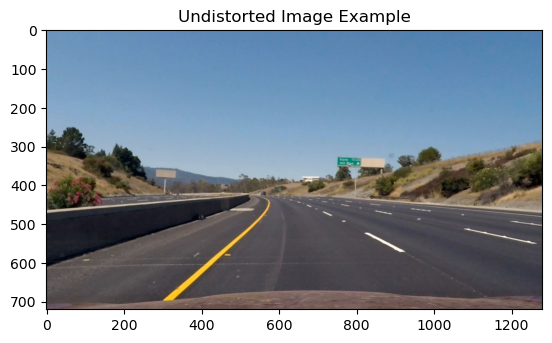

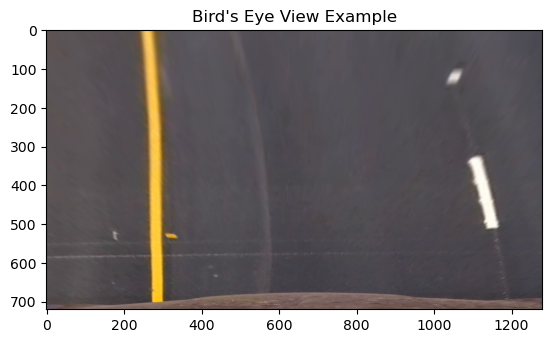

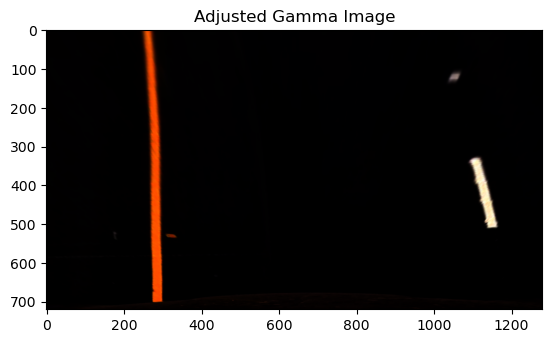

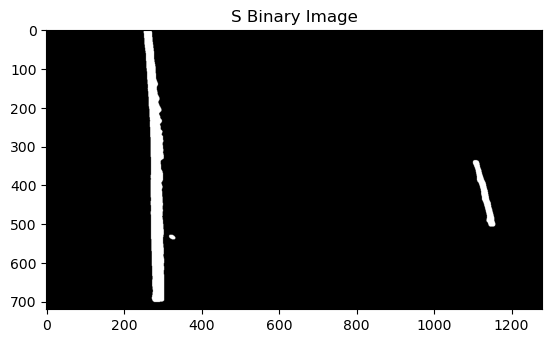

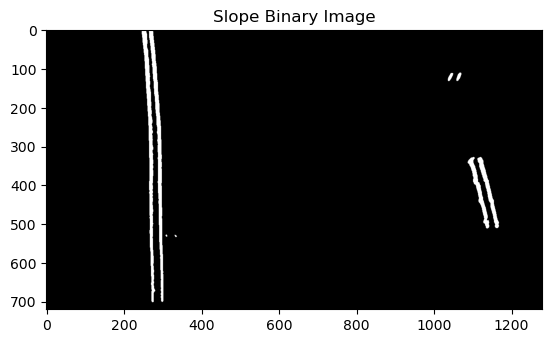

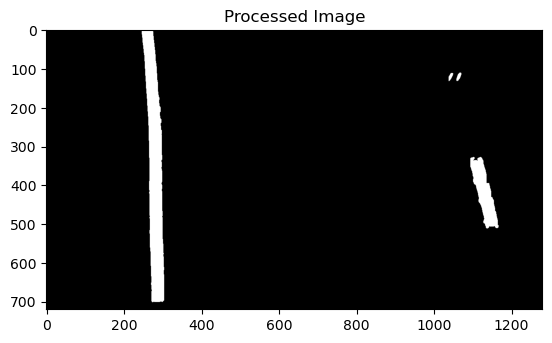

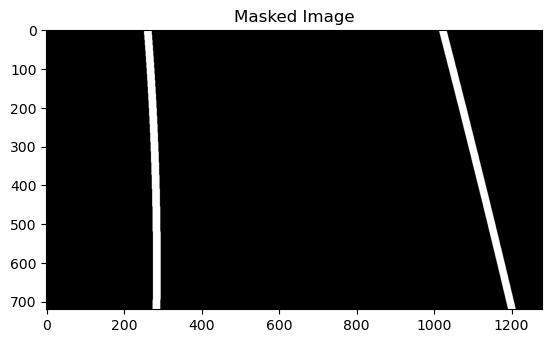

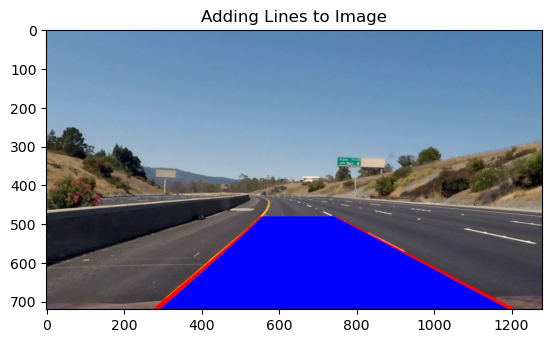

Moviepy - Building video ./output.mp4.
Moviepy - Writing video ./output.mp4



Moviepy - Done !
Moviepy - video ready ./output.mp4
Video build completed. Please view ./output.mp4


In [4]:
if __name__ == "__main__":
    cam_mtx, dist_coeff = get_cali_param('./camera_cal/calibration*.jpg')
    np.savez("./calibration.npz",mtx=cam_mtx, dist=dist_coeff)
    op = './output.mp4'
    clip = VideoFileClip('./project_video.mp4')
    ld = Line_detector()
    res_vid = clip.fl_image(ld.process_img)
    res_vid.write_videofile(op, audio=False)
    print("Video build completed. Please view %s" % op)

# Check Movie

In [5]:
HTML("""<video width="960" height="540" controls>
        <source src="{0}">
        </video>""".format("./output.mp4"))